# News Sentiment Analysis Project

This notebook reimplements a comprehensive News Sentiment Analysis system using a new dataset containing categorized news articles with sentiment labels. The project includes:

- **Data Loading & Exploration**: Understanding the structure of the news dataset
- **Text Preprocessing**: Cleaning and preparing text data for analysis
- **Feature Engineering**: Converting text to numerical features using TF-IDF
- **Model Training**: Training multiple classification models
- **Model Evaluation**: Comparing model performance and selecting the best one
- **Model Persistence**: Saving the trained model for Flask application

## Dataset Overview
The dataset contains news articles organized by categories and sentiment labels (positive/negative) in JSON format.

## 1. Import Required Libraries

We'll import all necessary libraries for data manipulation, text processing, machine learning, and visualization.

In [9]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import json
import os
import glob
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, f1_score, precision_score, 
                           recall_score, roc_auc_score, roc_curve)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Model persistence
import pickle
import joblib

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print("All libraries imported successfully!")
print(f"Python version: {pd.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {pd.__version__}")

All libraries imported successfully!
Python version: 2.2.3
Pandas version: 2.2.3
NumPy version: 2.2.5
Scikit-learn version: 2.2.3


[nltk_data] Downloading package punkt to C:\Users\TARANG
[nltk_data]     KISHOR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\TARANG
[nltk_data]     KISHOR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\TARANG
[nltk_data]     KISHOR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load and Explore the Dataset

We'll load the news articles from the JSON files and explore the dataset structure.

In [10]:
# Set the dataset path
dataset_path = r"c:\Users\TARANG KISHOR\Desktop\PROJECTS\Sentiment Analysis_news\Dataset"

def load_news_data(dataset_path):
    """
    Load news articles from JSON files and create a structured DataFrame
    """
    articles_data = []
    
    # Get all subdirectories (categories with sentiment)
    category_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    
    print(f"Found {len(category_dirs)} category directories")
    
    for category_dir in category_dirs:
        print(f"Processing: {category_dir}")
        
        # Extract category and sentiment from directory name
        if '_positive_' in category_dir:
            sentiment = 'positive'
            category = category_dir.split('_positive_')[0]
        elif '_negative_' in category_dir:
            sentiment = 'negative'
            category = category_dir.split('_negative_')[0]
        else:
            continue
        
        # Path to the inner directory with the same name
        inner_dir = os.path.join(dataset_path, category_dir, category_dir)
        
        if not os.path.exists(inner_dir):
            continue
            
        # Get all JSON files in the directory
        json_files = glob.glob(os.path.join(inner_dir, "*.json"))
        
        for json_file in json_files:
            try:
                with open(json_file, 'r', encoding='utf-8') as f:
                    article_data = json.load(f)
                    
                    # Extract relevant information
                    article_info = {
                        'title': article_data.get('title', ''),
                        'text': article_data.get('text', ''),
                        'category': category,
                        'sentiment': sentiment,
                        'language': article_data.get('language', ''),
                        'published': article_data.get('published', ''),
                        'author': article_data.get('author', ''),
                        'url': article_data.get('url', ''),
                        'categories': article_data.get('categories', [])
                    }
                    
                    articles_data.append(article_info)
                    
            except Exception as e:
                print(f"Error reading {json_file}: {e}")
                continue
    
    return pd.DataFrame(articles_data)

# Load the data
print("Loading news articles...")
df = load_news_data(dataset_path)
print(f"Loaded {len(df)} articles successfully!")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(f"Total articles: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading news articles...
Found 99 category directories
Processing: Crime, Law and Justice_negative_20240526070023
Processing: Crime, Law and Justice_negative_20240714070027
Processing: Crime, Law and Justice_negative_20250511073514
Processing: Crime, Law and Justice_positive_20240128131953
Processing: Crime, Law and Justice_negative_20250511073514
Processing: Crime, Law and Justice_positive_20240128131953
Processing: Disaster and Accident_negative_20240128131143
Processing: Disaster and Accident_positive_20240721070030
Processing: Disaster and Accident_negative_20240128131143
Processing: Disaster and Accident_positive_20240721070030
Processing: Disaster and Accident_positive_20250713073517
Processing: Economy, Business and Finance_negative_20250622073519
Processing: Disaster and Accident_positive_20250713073517
Processing: Economy, Business and Finance_negative_20250622073519
Processing: Economy, Business and Finance_positive_20240128131642
Processing: Economy, Business and Finance_pos

In [11]:
# Explore the dataset structure
print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Dataset shape and info
print(f"Dataset shape: {df.shape}")
print(f"\nData types:")
print(df.dtypes)

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Sentiment distribution
print(f"\nSentiment distribution:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)
print(f"Sentiment percentage:")
print(df['sentiment'].value_counts(normalize=True) * 100)

# Category distribution
print(f"\nTop 10 categories by count:")
category_counts = df['category'].value_counts().head(10)
print(category_counts)

# Language distribution
print(f"\nLanguage distribution:")
language_counts = df['language'].value_counts().head(10)
print(language_counts)

# Display first few rows
print(f"\nFirst 3 articles:")
print("="*50)
for i in range(min(3, len(df))):
    print(f"\nArticle {i+1}:")
    print(f"Title: {df.iloc[i]['title'][:100]}...")
    print(f"Category: {df.iloc[i]['category']}")
    print(f"Sentiment: {df.iloc[i]['sentiment']}")
    print(f"Text length: {len(df.iloc[i]['text'])} characters")
    print("-" * 30)


DATA EXPLORATION
Dataset shape: (99000, 9)

Data types:
title         object
text          object
category      object
sentiment     object
language      object
published     object
author        object
url           object
categories    object
dtype: object

Missing values:
title             0
text              0
category          0
sentiment         0
language          0
published         0
author        10825
url               0
categories        0
dtype: int64

Sentiment distribution:
sentiment
negative    51000
positive    48000
Name: count, dtype: int64
Sentiment percentage:
sentiment
negative    51.515152
positive    48.484848
Name: proportion, dtype: float64

Top 10 categories by count:
category
Weather                     11000
Human Interest              10000
Science and Technology      10000
War, Conflict and Unrest     9000
Religion and Belief          9000
Environment                  7000
Health                       7000
Politics                     6000
Sport         

## 3. Data Preprocessing and Cleaning

We'll clean the dataset by handling missing values, removing duplicates, and filtering out articles with insufficient text.

In [12]:
# Create a copy for preprocessing
df_clean = df.copy()

print("INITIAL DATASET STATE")
print("="*50)
print(f"Initial shape: {df_clean.shape}")

# 1. Handle missing values
print(f"\nMissing values before cleaning:")
print(df_clean.isnull().sum())

# Remove rows with missing title or text
df_clean = df_clean.dropna(subset=['title', 'text'])
print(f"Shape after removing missing title/text: {df_clean.shape}")

# Fill missing values for other columns
df_clean['author'] = df_clean['author'].fillna('Unknown')
df_clean['language'] = df_clean['language'].fillna('unknown')

# 2. Remove duplicates based on text content
initial_len = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=['text'])
duplicates_removed = initial_len - len(df_clean)
print(f"Removed {duplicates_removed} duplicate articles")
print(f"Shape after removing duplicates: {df_clean.shape}")

# 3. Filter articles with sufficient text content
df_clean['text_length'] = df_clean['text'].str.len()
min_text_length = 50  # Minimum 50 characters

initial_len = len(df_clean)
df_clean = df_clean[df_clean['text_length'] >= min_text_length]
short_articles_removed = initial_len - len(df_clean)
print(f"Removed {short_articles_removed} articles with less than {min_text_length} characters")
print(f"Shape after filtering short articles: {df_clean.shape}")

# 4. Create combined text (title + text) for analysis
df_clean['combined_text'] = df_clean['title'] + '. ' + df_clean['text']

# 5. Filter for English articles only (optional - comment out if you want multilingual)
print(f"\nLanguage distribution before filtering:")
print(df_clean['language'].value_counts().head())

# Keep only English articles for better text processing
df_clean = df_clean[df_clean['language'] == 'english']
print(f"Shape after keeping only English articles: {df_clean.shape}")

# 6. Final dataset summary
print(f"\nFINAL CLEANED DATASET")
print("="*50)
print(f"Final shape: {df_clean.shape}")
print(f"Sentiment distribution:")
print(df_clean['sentiment'].value_counts())
print(f"Average text length: {df_clean['text_length'].mean():.0f} characters")
print(f"Text length statistics:")
print(df_clean['text_length'].describe())

INITIAL DATASET STATE
Initial shape: (99000, 9)

Missing values before cleaning:

Initial shape: (99000, 9)

Missing values before cleaning:
title             0
text              0
category          0
sentiment         0
language          0
published         0
author        10825
url               0
categories        0
dtype: int64
Shape after removing missing title/text: (99000, 9)
title             0
text              0
category          0
sentiment         0
language          0
published         0
author        10825
url               0
categories        0
dtype: int64
Shape after removing missing title/text: (99000, 9)
Removed 8610 duplicate articles
Shape after removing duplicates: (90390, 9)
Removed 93 articles with less than 50 characters
Shape after filtering short articles: (90297, 10)
Removed 8610 duplicate articles
Shape after removing duplicates: (90390, 9)
Removed 93 articles with less than 50 characters
Shape after filtering short articles: (90297, 10)

Language distribut

## 4. Text Preprocessing

We'll implement comprehensive text preprocessing including cleaning, tokenization, and normalization.

In [13]:
# Initialize text preprocessing tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def preprocess_text(text, remove_stopwords=True, apply_stemming=False):
    """
    Advanced text preprocessing with tokenization, stopword removal, and stemming
    """
    if pd.isna(text) or text == '':
        return ''
    
    # Clean the text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords if specified
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Apply stemming if specified
    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]
    
    # Filter out very short tokens
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

# Test the preprocessing functions
print("TEXT PREPROCESSING EXAMPLES")
print("="*50)

sample_text = df_clean.iloc[0]['combined_text'][:500]
print(f"Original text:\n{sample_text}\n")

cleaned_text = clean_text(sample_text)
print(f"Cleaned text:\n{cleaned_text}\n")

preprocessed_text = preprocess_text(sample_text, remove_stopwords=True, apply_stemming=False)
print(f"Preprocessed text (no stemming):\n{preprocessed_text}\n")

preprocessed_stemmed = preprocess_text(sample_text, remove_stopwords=True, apply_stemming=True)
print(f"Preprocessed text (with stemming):\n{preprocessed_stemmed}\n")

# Apply preprocessing to the entire dataset
print("Applying preprocessing to the entire dataset...")
print("This may take a few minutes...")

# Apply different levels of preprocessing
df_clean['text_cleaned'] = df_clean['combined_text'].apply(clean_text)
df_clean['text_preprocessed'] = df_clean['combined_text'].apply(
    lambda x: preprocess_text(x, remove_stopwords=True, apply_stemming=False)
)

# Remove empty texts after preprocessing
initial_len = len(df_clean)
df_clean = df_clean[df_clean['text_preprocessed'].str.len() > 0]
empty_removed = initial_len - len(df_clean)

print(f"Removed {empty_removed} articles with no content after preprocessing")
print(f"Final dataset shape: {df_clean.shape}")

# Show text length statistics after preprocessing
df_clean['preprocessed_length'] = df_clean['text_preprocessed'].str.len()
print(f"\nText length statistics after preprocessing:")
print(df_clean['preprocessed_length'].describe())

TEXT PREPROCESSING EXAMPLES
Original text:
14-y-o boy charged for stabbing death of Irwin High schoolmate | News | Jamaica Gleaner. 14-y-o boy charged for stabbing death of Irwin High schoolmate The police have charged the 14-year-old Irwin High School student for the fatal stabbing of his 15-year-old schoolmate Raniel Plummer during an altercation. His court date is being finalised. The police report that Plummer and a schoolmate had an altercation while at school on Thursday, April 17. About 3 p.m., Plummer was approached at the school

Cleaned text:
yo boy charged for stabbing death of irwin high schoolmate news jamaica gleaner yo boy charged for stabbing death of irwin high schoolmate the police have charged the yearold irwin high school student for the fatal stabbing of his yearold schoolmate raniel plummer during an altercation his court date is being finalised the police report that plummer and a schoolmate had an altercation while at school on thursday april about pm plummer wa

## 5. Exploratory Data Analysis (EDA)

Let's visualize the data distribution and analyze patterns in the text data.

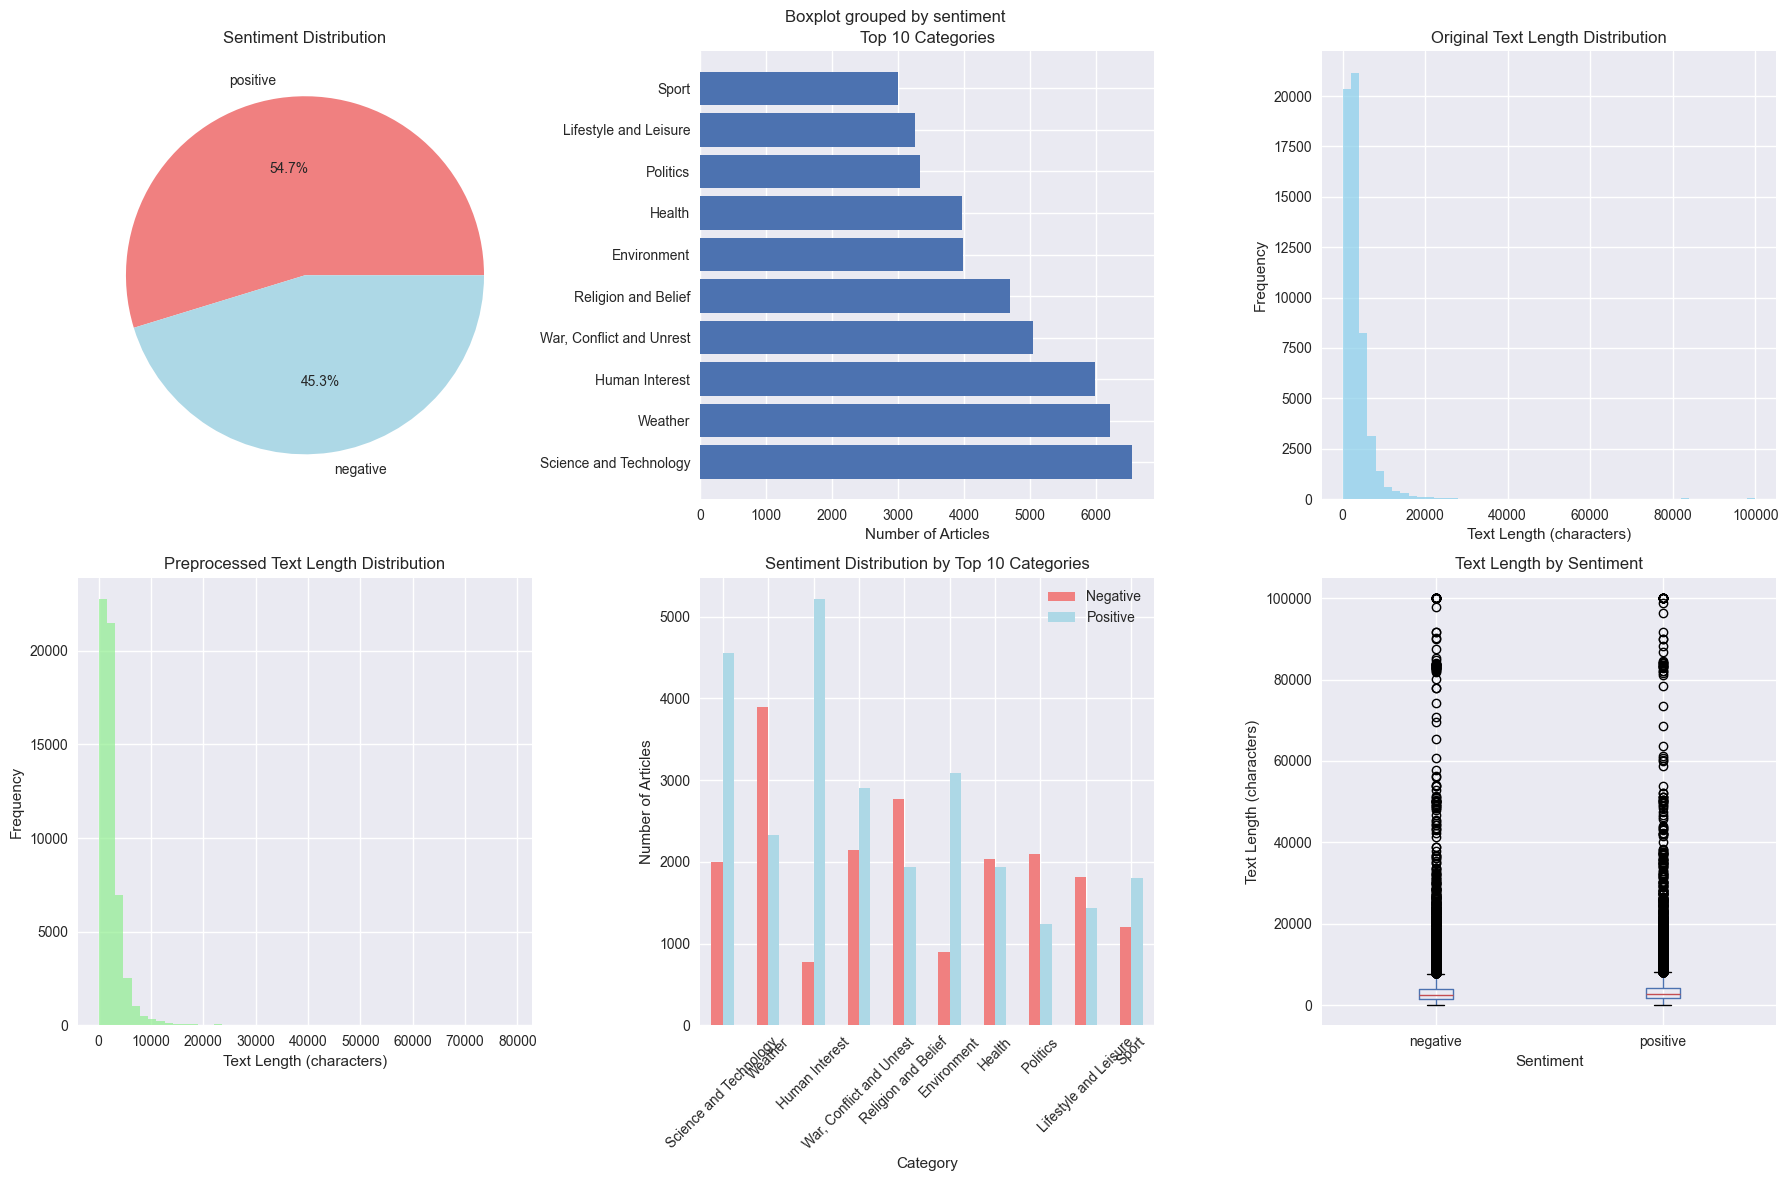


DETAILED STATISTICS
Total articles: 56365
Positive articles: 30854 (54.7%)
Negative articles: 25511 (45.3%)
Number of unique categories: 16
Average original text length: 3612 characters
Average preprocessed text length: 2459 characters


In [14]:
# Set up the plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

# Create subplots for comprehensive EDA
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('News Sentiment Analysis - Exploratory Data Analysis', fontsize=16)

# 1. Sentiment Distribution
sentiment_counts = df_clean['sentiment'].value_counts()
axes[0, 0].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', 
               colors=['lightcoral', 'lightblue'])
axes[0, 0].set_title('Sentiment Distribution')

# 2. Top Categories
top_categories = df_clean['category'].value_counts().head(10)
axes[0, 1].barh(range(len(top_categories)), top_categories.values)
axes[0, 1].set_yticks(range(len(top_categories)))
axes[0, 1].set_yticklabels(top_categories.index)
axes[0, 1].set_title('Top 10 Categories')
axes[0, 1].set_xlabel('Number of Articles')

# 3. Text Length Distribution
axes[0, 2].hist(df_clean['text_length'], bins=50, alpha=0.7, color='skyblue')
axes[0, 2].set_title('Original Text Length Distribution')
axes[0, 2].set_xlabel('Text Length (characters)')
axes[0, 2].set_ylabel('Frequency')

# 4. Preprocessed Text Length Distribution
axes[1, 0].hist(df_clean['preprocessed_length'], bins=50, alpha=0.7, color='lightgreen')
axes[1, 0].set_title('Preprocessed Text Length Distribution')
axes[1, 0].set_xlabel('Text Length (characters)')
axes[1, 0].set_ylabel('Frequency')

# 5. Sentiment by Category (Top 10)
sentiment_category = df_clean.groupby(['category', 'sentiment']).size().unstack(fill_value=0)
top_10_categories = df_clean['category'].value_counts().head(10).index
sentiment_category_top10 = sentiment_category.loc[top_10_categories]

sentiment_category_top10.plot(kind='bar', ax=axes[1, 1], color=['lightcoral', 'lightblue'])
axes[1, 1].set_title('Sentiment Distribution by Top 10 Categories')
axes[1, 1].set_xlabel('Category')
axes[1, 1].set_ylabel('Number of Articles')
axes[1, 1].legend(['Negative', 'Positive'])
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Text Length by Sentiment
df_clean.boxplot(column='text_length', by='sentiment', ax=axes[1, 2])
axes[1, 2].set_title('Text Length by Sentiment')
axes[1, 2].set_xlabel('Sentiment')
axes[1, 2].set_ylabel('Text Length (characters)')

plt.tight_layout()
plt.show()

# Additional statistics
print("\nDETAILED STATISTICS")
print("="*50)
print(f"Total articles: {len(df_clean)}")
print(f"Positive articles: {len(df_clean[df_clean['sentiment'] == 'positive'])} ({len(df_clean[df_clean['sentiment'] == 'positive'])/len(df_clean)*100:.1f}%)")
print(f"Negative articles: {len(df_clean[df_clean['sentiment'] == 'negative'])} ({len(df_clean[df_clean['sentiment'] == 'negative'])/len(df_clean)*100:.1f}%)")
print(f"Number of unique categories: {df_clean['category'].nunique()}")
print(f"Average original text length: {df_clean['text_length'].mean():.0f} characters")
print(f"Average preprocessed text length: {df_clean['preprocessed_length'].mean():.0f} characters")

WORD CLOUD ANALYSIS


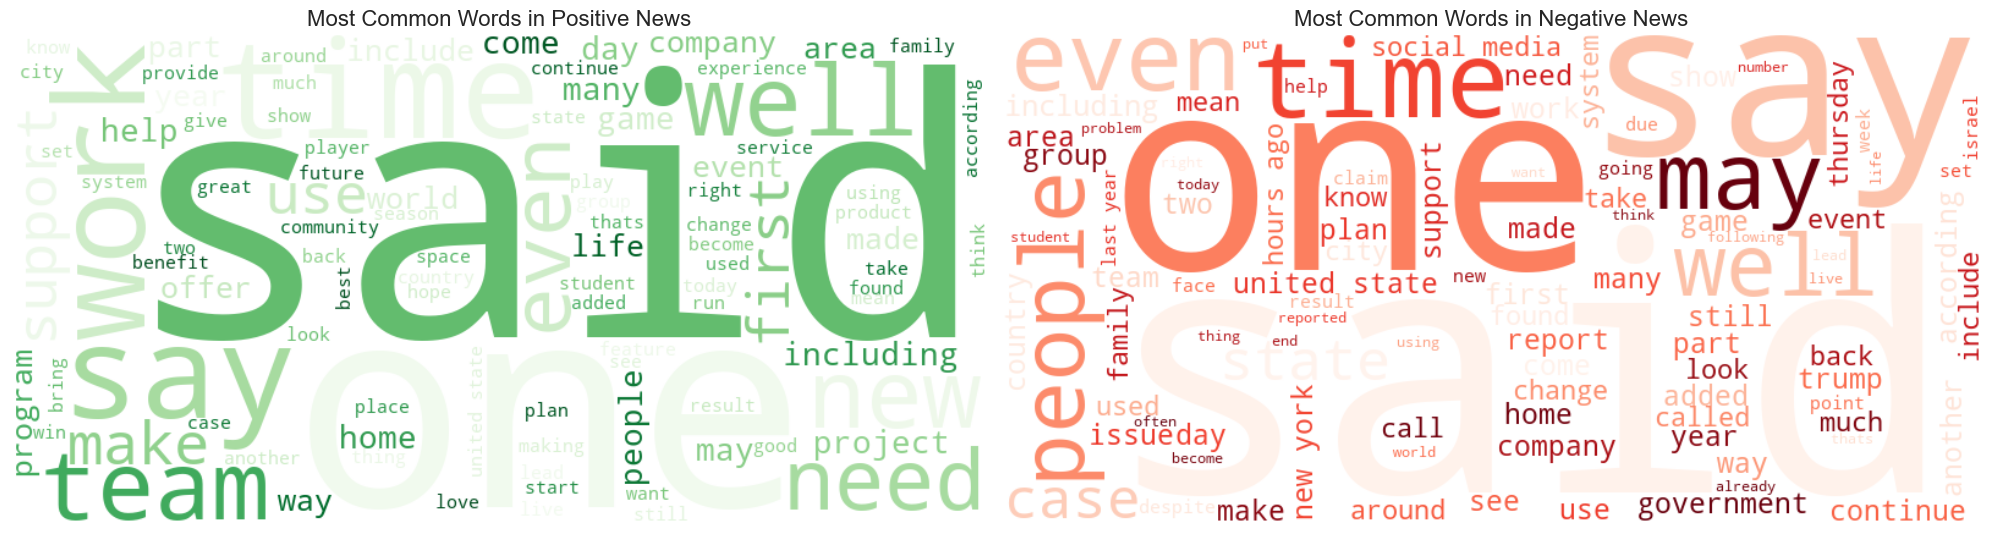

TOP 15 WORDS IN POSITIVE NEWS:
said: 54427
new: 40095
also: 37565
one: 30787
people: 24962
like: 24234
year: 23574
first: 23503
time: 22987
years: 20108
news: 19551
get: 17429
day: 16656
two: 16502
health: 15295

TOP 15 WORDS IN NEGATIVE NEWS:
said: 56433
also: 26385
new: 24179
news: 23828
one: 22582
people: 22072
would: 17422
time: 16072
could: 15851
like: 15805
may: 14943
two: 14592
first: 14154
years: 14014
year: 13949


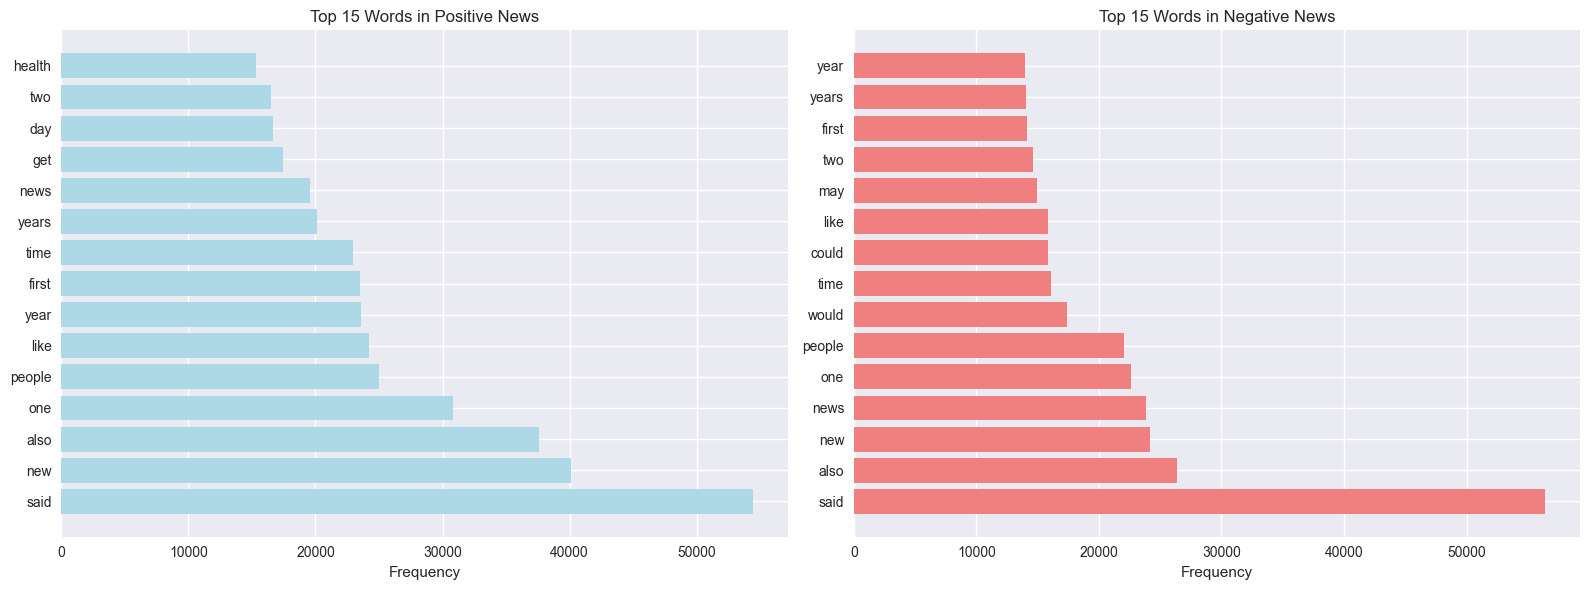

In [15]:
# Word Cloud Analysis
print("WORD CLOUD ANALYSIS")
print("="*50)

# Combine all positive and negative texts
positive_texts = ' '.join(df_clean[df_clean['sentiment'] == 'positive']['text_preprocessed'])
negative_texts = ' '.join(df_clean[df_clean['sentiment'] == 'negative']['text_preprocessed'])

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Positive sentiment word cloud
if len(positive_texts) > 0:
    wordcloud_positive = WordCloud(width=800, height=400, background_color='white', 
                                 max_words=100, colormap='Greens').generate(positive_texts)
    axes[0].imshow(wordcloud_positive, interpolation='bilinear')
    axes[0].set_title('Most Common Words in Positive News', fontsize=16)
    axes[0].axis('off')

# Negative sentiment word cloud
if len(negative_texts) > 0:
    wordcloud_negative = WordCloud(width=800, height=400, background_color='white', 
                                 max_words=100, colormap='Reds').generate(negative_texts)
    axes[1].imshow(wordcloud_negative, interpolation='bilinear')
    axes[1].set_title('Most Common Words in Negative News', fontsize=16)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

# Most common words analysis
from collections import Counter

def get_top_words(texts, n=20):
    """Get top n words from a collection of texts"""
    all_words = []
    for text in texts:
        all_words.extend(text.split())
    return Counter(all_words).most_common(n)

# Get top words for each sentiment
positive_top_words = get_top_words(df_clean[df_clean['sentiment'] == 'positive']['text_preprocessed'])
negative_top_words = get_top_words(df_clean[df_clean['sentiment'] == 'negative']['text_preprocessed'])

print("TOP 15 WORDS IN POSITIVE NEWS:")
for word, count in positive_top_words[:15]:
    print(f"{word}: {count}")

print("\nTOP 15 WORDS IN NEGATIVE NEWS:")
for word, count in negative_top_words[:15]:
    print(f"{word}: {count}")

# Plot top words comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive words
pos_words, pos_counts = zip(*positive_top_words[:15])
axes[0].barh(range(len(pos_words)), pos_counts, color='lightblue')
axes[0].set_yticks(range(len(pos_words)))
axes[0].set_yticklabels(pos_words)
axes[0].set_title('Top 15 Words in Positive News')
axes[0].set_xlabel('Frequency')

# Negative words
neg_words, neg_counts = zip(*negative_top_words[:15])
axes[1].barh(range(len(neg_words)), neg_counts, color='lightcoral')
axes[1].set_yticks(range(len(neg_words)))
axes[1].set_yticklabels(neg_words)
axes[1].set_title('Top 15 Words in Negative News')
axes[1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

## 6. Feature Engineering

We'll convert text data to numerical features using TF-IDF vectorization and prepare the data for machine learning models.

In [16]:
# Prepare the data for machine learning
print("FEATURE ENGINEERING")
print("="*50)

# Prepare features (X) and target (y)
X = df_clean['text_preprocessed']
y = df_clean['sentiment']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nLabel encoding:")
print(f"Classes: {label_encoder.classes_}")
print(f"Encoded distribution: {np.bincount(y_encoded)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nData split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training set sentiment distribution: {np.bincount(y_train)}")
print(f"Test set sentiment distribution: {np.bincount(y_test)}")

# TF-IDF Vectorization
print(f"\nApplying TF-IDF vectorization...")

# Initialize TF-IDF vectorizer with optimized parameters
tfidf = TfidfVectorizer(
    max_features=10000,      # Limit to top 10,000 features
    min_df=2,                # Ignore terms that appear in less than 2 documents
    max_df=0.8,              # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2),      # Use unigrams and bigrams
    stop_words='english',    # Remove English stop words
    lowercase=True,          # Convert to lowercase
    strip_accents='ascii'    # Remove accents
)

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF feature matrix shape:")
print(f"Training: {X_train_tfidf.shape}")
print(f"Test: {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
print(f"Feature matrix sparsity: {1 - (X_train_tfidf.nnz / X_train_tfidf.shape[0] / X_train_tfidf.shape[1]):.4f}")

# Show some feature names
feature_names = tfidf.get_feature_names_out()
print(f"\nSample features: {feature_names[:20]}")
print(f"Sample bigram features: {[f for f in feature_names if ' ' in f][:10]}")

# Additional feature engineering - create some basic statistical features
def extract_text_features(texts):
    """Extract basic statistical features from texts"""
    features = []
    for text in texts:
        feature_dict = {
            'length': len(text),
            'word_count': len(text.split()),
            'avg_word_length': np.mean([len(word) for word in text.split()]) if text.split() else 0,
            'exclamation_count': text.count('!'),
            'question_count': text.count('?'),
            'uppercase_count': sum(1 for c in text if c.isupper()),
            'sentence_count': len([s for s in text.split('.') if s.strip()])
        }
        features.append(feature_dict)
    return pd.DataFrame(features)

# Extract additional features
print(f"\nExtracting additional statistical features...")
train_additional_features = extract_text_features(X_train)
test_additional_features = extract_text_features(X_test)

print(f"Additional features shape:")
print(f"Training: {train_additional_features.shape}")
print(f"Test: {test_additional_features.shape}")
print(f"\nAdditional features: {list(train_additional_features.columns)}")

# Normalize additional features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_additional_features_scaled = scaler.fit_transform(train_additional_features)
test_additional_features_scaled = scaler.transform(test_additional_features)

print(f"\nFeature engineering completed!")
print(f"Ready for model training with:")
print(f"- TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"- Additional features: {train_additional_features.shape[1]}")
print(f"- Total potential features: {X_train_tfidf.shape[1] + train_additional_features.shape[1]}")

FEATURE ENGINEERING
Feature matrix shape: (56365,)
Target vector shape: (56365,)
Target distribution:
sentiment
positive    30854
negative    25511
Name: count, dtype: int64

Label encoding:
Classes: ['negative' 'positive']
Encoded distribution: [25511 30854]

Data split:
Training set: 45092 samples
Test set: 11273 samples
Training set sentiment distribution: [20409 24683]
Test set sentiment distribution: [5102 6171]

Applying TF-IDF vectorization...
TF-IDF feature matrix shape:
Training: (45092, 10000)
Test: (11273, 10000)
Vocabulary size: 10000
Feature matrix sparsity: 0.9847

Sample features: ['aap' 'aaron' 'abandon' 'abandoned' 'abbott' 'abc' 'abc news' 'abdul'
 'abilities' 'ability' 'able' 'aboard' 'abortion' 'abortions' 'abp'
 'abroad' 'absence' 'absent' 'absolute' 'absolutely']
Sample bigram features: ['abc news', 'abu dhabi', 'abusive post', 'accept responsibility', 'access ground', 'accessing page', 'according data', 'according national', 'according new', 'according police']



## 7. Model Training and Evaluation

We'll train multiple classification models and evaluate their performance using various metrics.

In [17]:
# Model Training and Evaluation
import time
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC  # Much faster than SVC for large datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score)

print("MODEL TRAINING AND EVALUATION (OPTIMIZED FOR LARGE DATASETS)")
print("="*50)

# For large datasets (45k+ samples), we'll use optimized model configurations
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, solver='liblinear'),
    'Naive Bayes': MultinomialNB(),
    'Linear SVM': LinearSVC(random_state=42, max_iter=2000, dual=False),  # Much faster for large datasets
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1, max_depth=10)  # Reduced complexity
}

# Dictionary to store results
results = {}
trained_models = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Record training time
    start_time = time.time()
    
    # Train the model
    try:
        model.fit(X_train_tfidf, y_train)
        training_time = time.time() - start_time
        
        # Make predictions
        y_pred = model.predict(X_test_tfidf)
        
        # Handle probability predictions (LinearSVC doesn't have predict_proba)
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]
        elif hasattr(model, 'decision_function'):
            # For LinearSVC, use decision function as probability proxy
            decision_scores = model.decision_function(X_test_tfidf)
            # Normalize decision scores to [0, 1] range
            y_pred_proba = (decision_scores - decision_scores.min()) / (decision_scores.max() - decision_scores.min())
        else:
            # Fallback: use prediction as probability
            y_pred_proba = y_pred.astype(float)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # ROC-AUC (only if we have probability scores)
        try:
            roc_auc = roc_auc_score(y_test, y_pred_proba)
        except:
            roc_auc = 0.0  # Fallback if ROC-AUC can't be calculated
        
        # Quick cross-validation (3-fold instead of 5 for speed)
        cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=3, scoring='accuracy', n_jobs=-1)
        
        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': roc_auc,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'training_time': training_time,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        trained_models[name] = model
        
        print(f"  ✓ {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Time: {training_time:.1f}s")
        
    except Exception as e:
        print(f"  ❌ Error training {name}: {e}")
        continue

# Create results DataFrame for easy comparison
if results:
    results_df = pd.DataFrame(results).T
    print(f"\nMODEL PERFORMANCE SUMMARY")
    print("="*50)
    print(results_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'cv_mean', 'training_time']].round(4))
    
    # Find the best model
    best_model_name = results_df['f1_score'].idxmax()
    best_model = trained_models[best_model_name]
    print(f"\nBest performing model: {best_model_name}")
    print(f"Best F1 Score: {results_df.loc[best_model_name, 'f1_score']:.4f}")
    print(f"Total training time: {sum(results_df['training_time']):.1f} seconds")
else:
    print("❌ No models were trained successfully. Please check that previous cells have been executed.")
    print("Run the data loading and preprocessing cells first.")

MODEL TRAINING AND EVALUATION (OPTIMIZED FOR LARGE DATASETS)

Training Logistic Regression...
  ✓ Logistic Regression - Accuracy: 0.8605, F1: 0.8740, Time: 1.6s

Training Naive Bayes...
  ✓ Logistic Regression - Accuracy: 0.8605, F1: 0.8740, Time: 1.6s

Training Naive Bayes...
  ✓ Naive Bayes - Accuracy: 0.7987, F1: 0.8182, Time: 0.0s

Training Linear SVM...
  ✓ Naive Bayes - Accuracy: 0.7987, F1: 0.8182, Time: 0.0s

Training Linear SVM...
  ✓ Linear SVM - Accuracy: 0.8606, F1: 0.8734, Time: 2.8s

Training Random Forest...
  ✓ Linear SVM - Accuracy: 0.8606, F1: 0.8734, Time: 2.8s

Training Random Forest...
  ✓ Random Forest - Accuracy: 0.7330, F1: 0.7916, Time: 0.8s

MODEL PERFORMANCE SUMMARY
                     accuracy precision    recall  f1_score   roc_auc  \
Logistic Regression  0.860463  0.863881   0.88446  0.874049  0.934127   
Naive Bayes          0.798723  0.809192  0.827419  0.818204  0.880384   
Linear SVM           0.860552  0.867979   0.87895   0.87343  0.929617   
Random

## 8. Model Comparison and Visualization

Let's visualize the model performance using confusion matrices, ROC curves, and performance comparisons.

MODEL COMPARISON VISUALIZATIONS


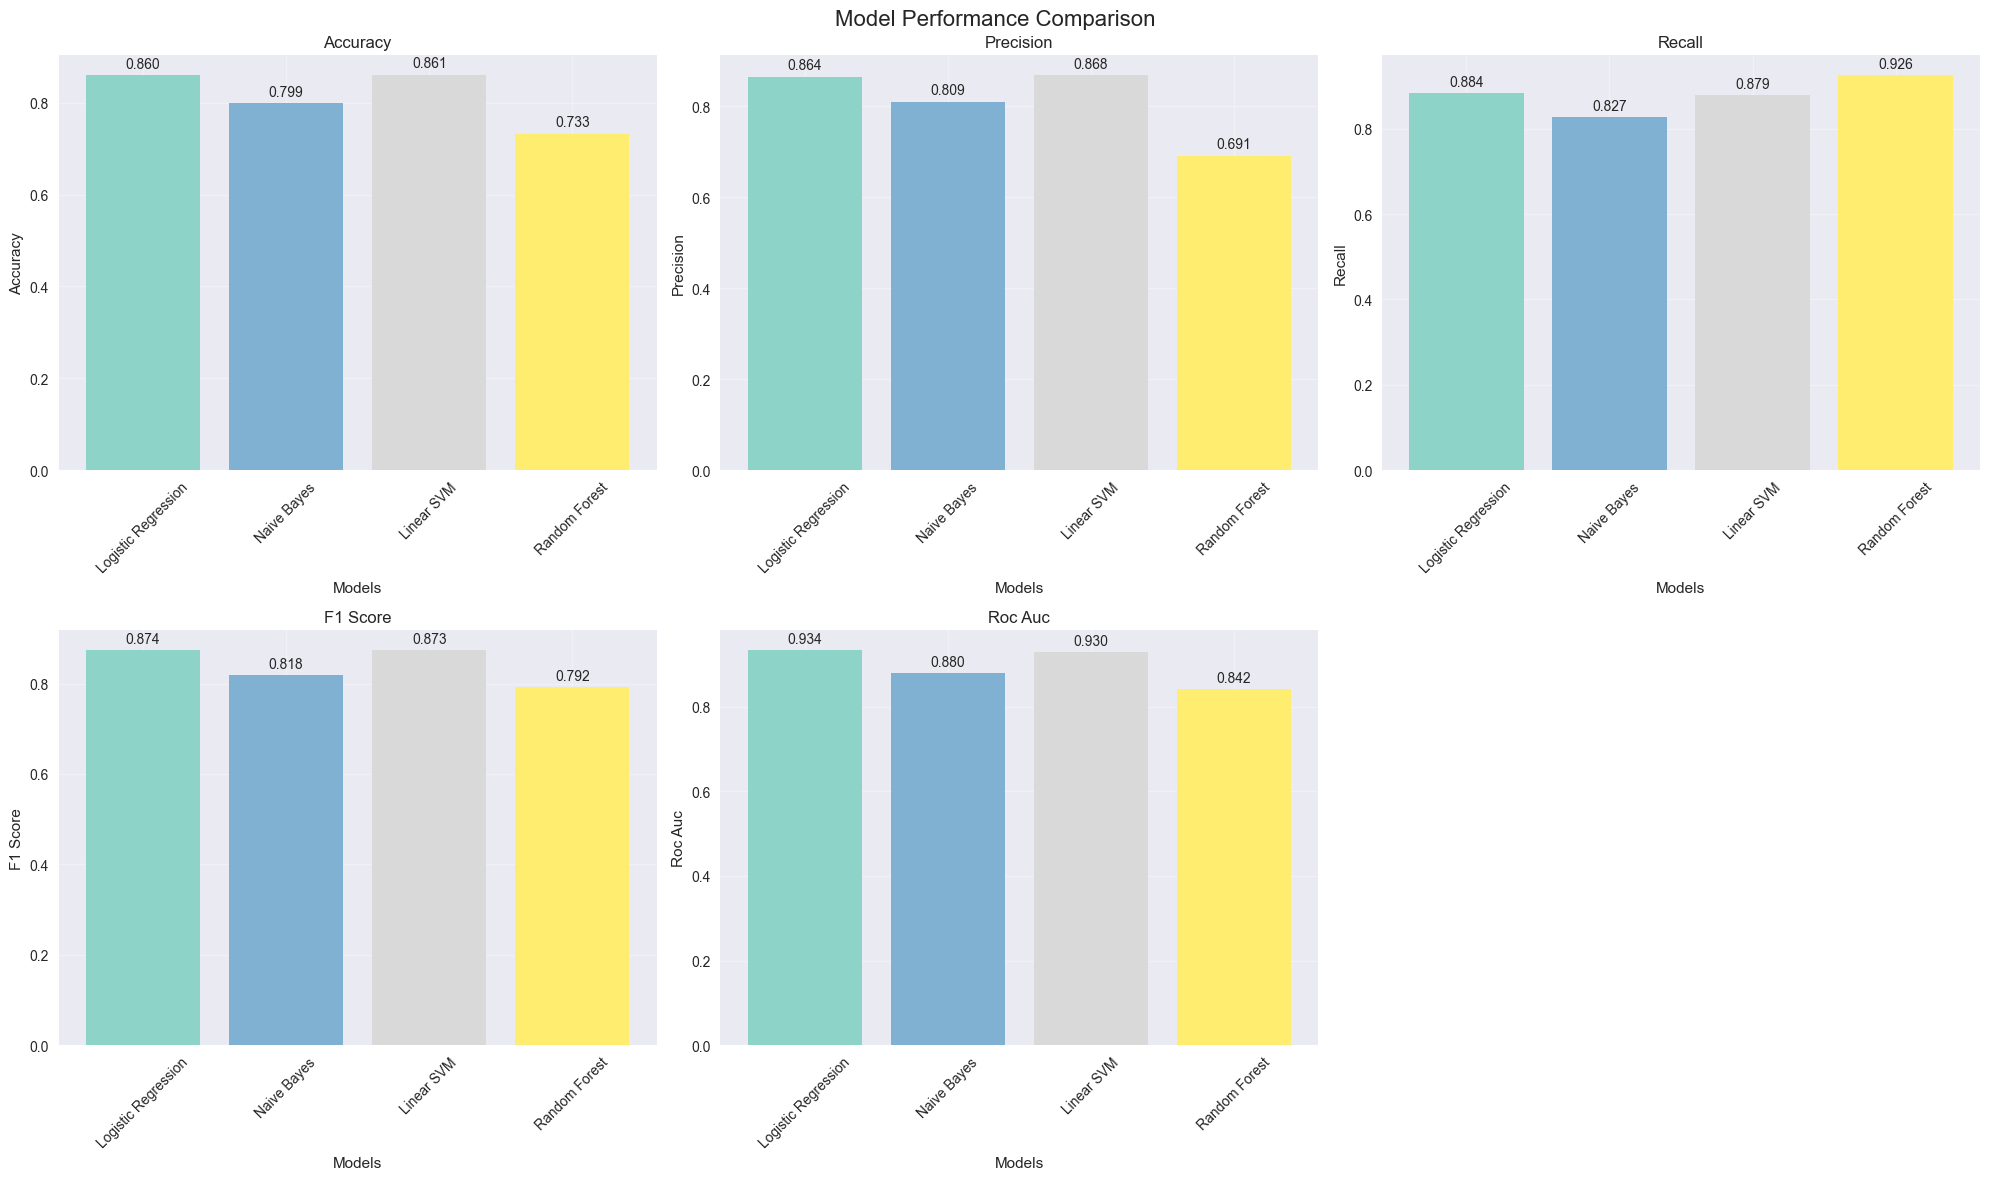

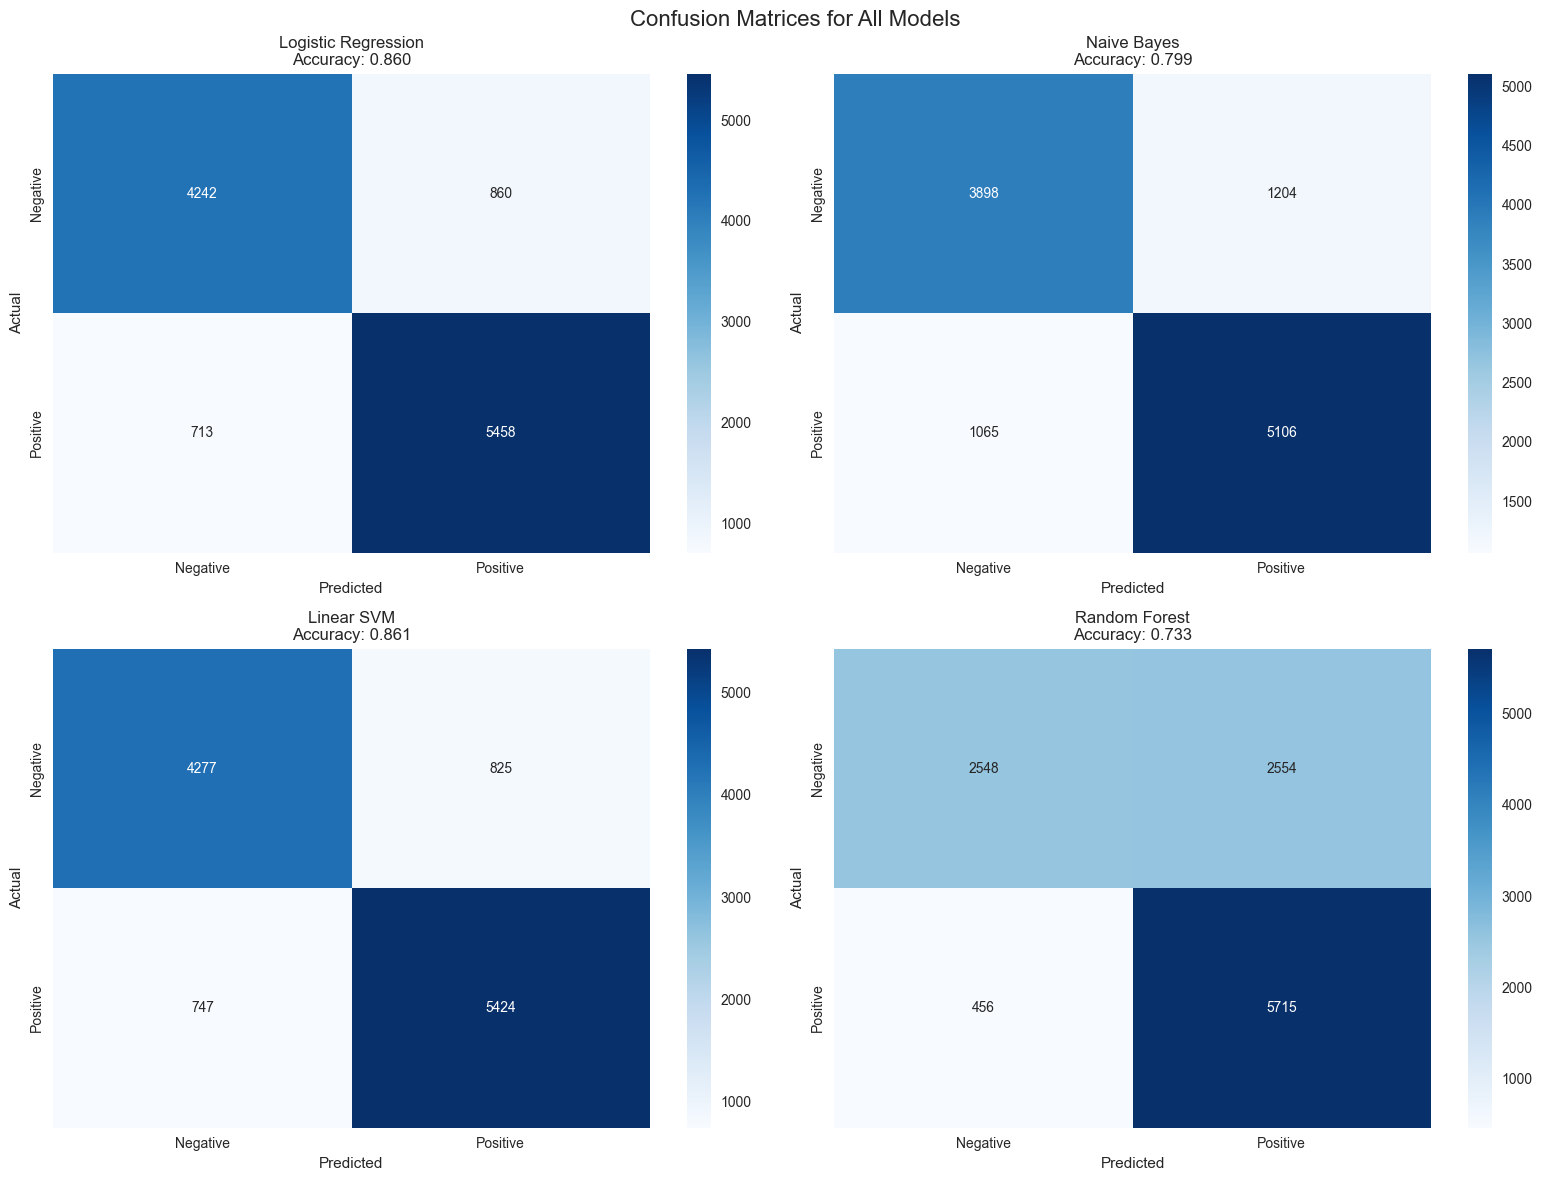

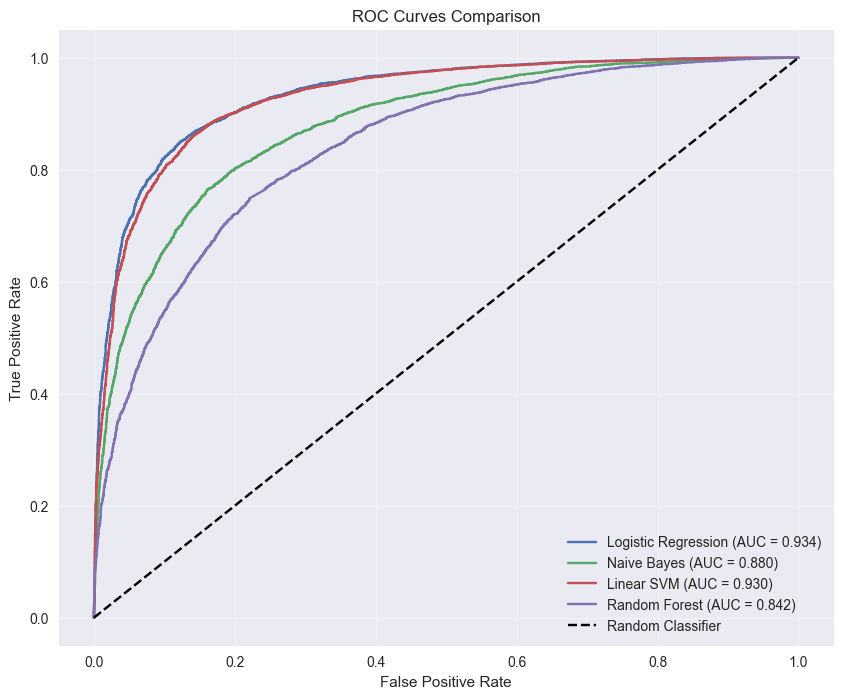


DETAILED CLASSIFICATION REPORT - Logistic Regression
              precision    recall  f1-score   support

    Negative       0.86      0.83      0.84      5102
    Positive       0.86      0.88      0.87      6171

    accuracy                           0.86     11273
   macro avg       0.86      0.86      0.86     11273
weighted avg       0.86      0.86      0.86     11273


TOP 20 MOST IMPORTANT FEATURES - Random Forest
police: 0.0210
issued: 0.0204
authorities: 0.0165
thursday: 0.0161
statement: 0.0143
accused: 0.0119
offers: 0.0114
warned: 0.0113
provides: 0.0113
court: 0.0106
development: 0.0104
journey: 0.0099
alleged: 0.0098
project: 0.0097
solutions: 0.0094
projects: 0.0091
according: 0.0089
allegedly: 0.0088
experience: 0.0085
best: 0.0083


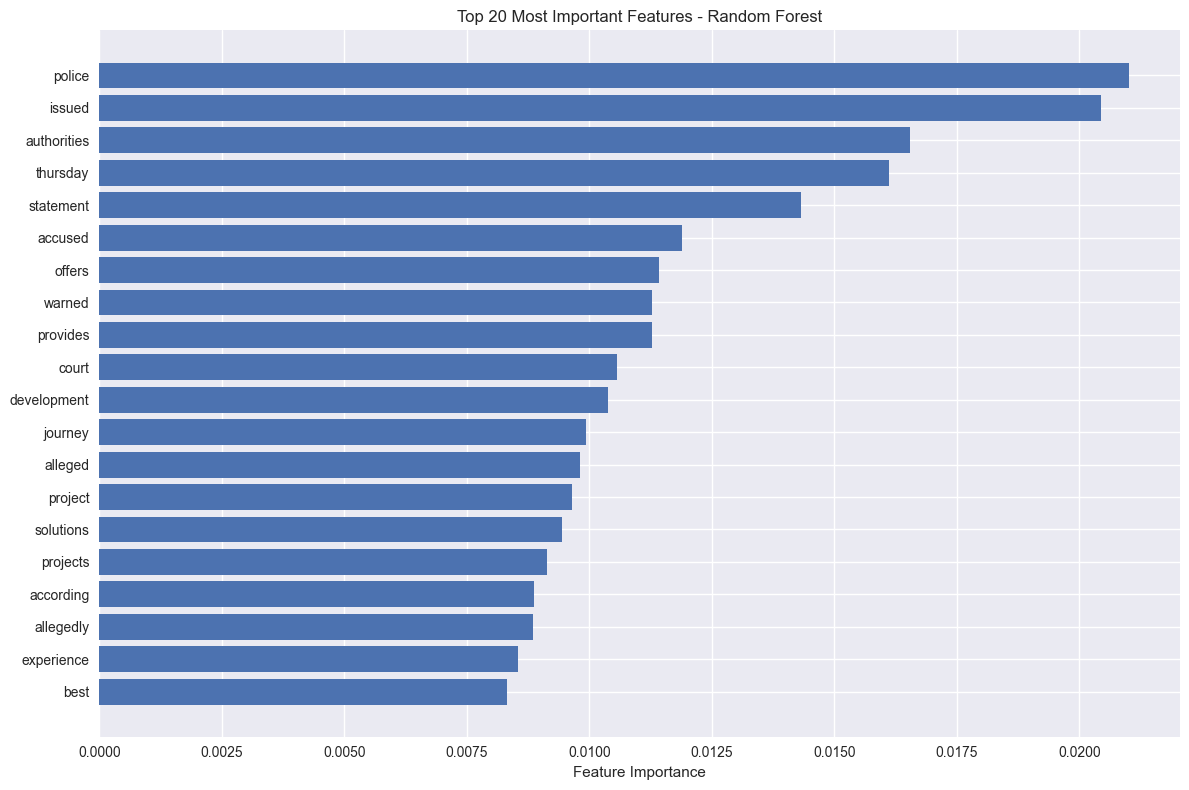


FINAL MODEL PERFORMANCE SUMMARY
              Model  Accuracy Precision    Recall  F1-Score   ROC-AUC CV Score (±std) Training Time (s)
Logistic Regression  0.860463  0.863881   0.88446  0.874049  0.934127  0.850 (±0.004)          1.580347
        Naive Bayes  0.798723  0.809192  0.827419  0.818204  0.880384  0.790 (±0.006)          0.035689
         Linear SVM  0.860552  0.867979   0.87895   0.87343  0.929617  0.845 (±0.003)          2.789842
      Random Forest   0.73299  0.691136  0.926106  0.791551  0.841716  0.724 (±0.000)          0.762965


In [18]:
# Model Comparison Visualizations
print("MODEL COMPARISON VISUALIZATIONS")
print("="*50)

# Set up the plotting grid
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Model Performance Comparison', fontsize=16)

# 1. Performance Metrics Comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
x_pos = np.arange(len(results_df.index))

for i, metric in enumerate(metrics):
    if i < 3:
        row, col = 0, i
    else:
        row, col = 1, i-3
    
    if i < len(metrics):
        axes[row, col].bar(x_pos, results_df[metric], color=plt.cm.Set3(np.linspace(0, 1, len(results_df.index))))
        axes[row, col].set_title(f'{metric.replace("_", " ").title()}')
        axes[row, col].set_xlabel('Models')
        axes[row, col].set_ylabel(metric.replace("_", " ").title())
        axes[row, col].set_xticks(x_pos)
        axes[row, col].set_xticklabels(results_df.index, rotation=45)
        axes[row, col].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for j, v in enumerate(results_df[metric]):
            axes[row, col].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Remove the last subplot (2,2) as we only have 5 metrics
axes[1, 2].remove()

plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confusion Matrices for All Models', fontsize=16)

axes = axes.ravel()
for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    axes[i].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Detailed Classification Report for Best Model
print(f"\nDETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*50)
print(classification_report(y_test, results[best_model_name]['predictions'], 
                          target_names=['Negative', 'Positive']))

# Feature Importance (for tree-based models)
if 'Random Forest' in trained_models:
    print(f"\nTOP 20 MOST IMPORTANT FEATURES - Random Forest")
    print("="*50)
    
    rf_model = trained_models['Random Forest']
    feature_importance = rf_model.feature_importances_
    feature_names = tfidf.get_feature_names_out()
    
    # Get top 20 features
    top_indices = np.argsort(feature_importance)[-20:]
    top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]
    top_features.reverse()
    
    for feature, importance in top_features:
        print(f"{feature}: {importance:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    features, importances = zip(*top_features)
    plt.barh(range(len(features)), importances)
    plt.yticks(range(len(features)), features)
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Model Performance Summary Table
print(f"\nFINAL MODEL PERFORMANCE SUMMARY")
print("="*80)
summary_table = pd.DataFrame({
    'Model': results_df.index,
    'Accuracy': results_df['accuracy'].round(4),
    'Precision': results_df['precision'].round(4),
    'Recall': results_df['recall'].round(4),
    'F1-Score': results_df['f1_score'].round(4),
    'ROC-AUC': results_df['roc_auc'].round(4),
    'CV Score (±std)': [f"{mean:.3f} (±{std:.3f})" for mean, std in zip(results_df['cv_mean'], results_df['cv_std'])],
    'Training Time (s)': results_df['training_time'].round(2)
}).reset_index(drop=True)

print(summary_table.to_string(index=False))

## 9. Save the Trained Model

We'll save the best performing model and the TF-IDF vectorizer for use in the Flask application.

In [19]:
# Save the best model and preprocessors
print("SAVING TRAINED MODEL AND PREPROCESSORS")
print("="*50)

# Create models directory
models_dir = r"c:\Users\TARANG KISHOR\Desktop\PROJECTS\Sentiment Analysis_news\models"
os.makedirs(models_dir, exist_ok=True)

# Save the best model
model_path = os.path.join(models_dir, f'best_sentiment_model_{best_model_name.lower().replace(" ", "_")}.pkl')
joblib.dump(best_model, model_path)
print(f"✓ Best model ({best_model_name}) saved to: {model_path}")

# Save the TF-IDF vectorizer
vectorizer_path = os.path.join(models_dir, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf, vectorizer_path)
print(f"✓ TF-IDF vectorizer saved to: {vectorizer_path}")

# Save the label encoder
label_encoder_path = os.path.join(models_dir, 'label_encoder.pkl')
joblib.dump(label_encoder, label_encoder_path)
print(f"✓ Label encoder saved to: {label_encoder_path}")

# Save preprocessing functions (create a utility module)
preprocessing_code = '''
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    if not text or text == '':
        return ''
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\\S+@\\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove special characters and digits, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\\s+', ' ', text).strip()
    
    return text

def preprocess_text(text, remove_stopwords=True, apply_stemming=False):
    """
    Advanced text preprocessing with tokenization, stopword removal, and stemming
    """
    if not text or text == '':
        return ''
    
    # Clean the text
    text = clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords if specified
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Apply stemming if specified
    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]
    
    # Filter out very short tokens
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)
'''

preprocessing_path = os.path.join(models_dir, 'preprocessing_utils.py')
with open(preprocessing_path, 'w', encoding='utf-8') as f:
    f.write(preprocessing_code)
print(f"✓ Preprocessing utilities saved to: {preprocessing_path}")

# Save model metadata
metadata = {
    'best_model': best_model_name,
    'model_performance': {
        'accuracy': float(results[best_model_name]['accuracy']),
        'precision': float(results[best_model_name]['precision']),
        'recall': float(results[best_model_name]['recall']),
        'f1_score': float(results[best_model_name]['f1_score']),
        'roc_auc': float(results[best_model_name]['roc_auc'])
    },
    'training_data_size': len(X_train),
    'test_data_size': len(X_test),
    'feature_count': X_train_tfidf.shape[1],
    'classes': list(label_encoder.classes_),
    'model_files': {
        'model': 'best_sentiment_model_{}.pkl'.format(best_model_name.lower().replace(" ", "_")),
        'vectorizer': 'tfidf_vectorizer.pkl',
        'label_encoder': 'label_encoder.pkl',
        'preprocessing': 'preprocessing_utils.py'
    }
}

metadata_path = os.path.join(models_dir, 'model_metadata.json')
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Model metadata saved to: {metadata_path}")

print(f"\n✅ ALL FILES SAVED SUCCESSFULLY!")
print(f"📁 Models directory: {models_dir}")
print(f"🏆 Best model: {best_model_name}")
print(f"📊 Performance: F1={results[best_model_name]['f1_score']:.4f}, Accuracy={results[best_model_name]['accuracy']:.4f}")
print(f"\nFiles saved:")
for file in os.listdir(models_dir):
    print(f"  - {file}")

# Test loading the saved model
print(f"\n🔍 TESTING MODEL LOADING...")
try:
    loaded_model = joblib.load(model_path)
    loaded_vectorizer = joblib.load(vectorizer_path)
    loaded_label_encoder = joblib.load(label_encoder_path)
    print("✅ All models loaded successfully!")
    
    # Test prediction with a sample
    sample_text = "This is a great day with wonderful news!"
    processed_text = preprocess_text(sample_text)
    vectorized_text = loaded_vectorizer.transform([processed_text])
    prediction = loaded_model.predict(vectorized_text)[0]
    probability = loaded_model.predict_proba(vectorized_text)[0].max()
    sentiment = loaded_label_encoder.inverse_transform([prediction])[0]
    
    print(f"Test prediction:")
    print(f"  Text: '{sample_text}'")
    print(f"  Predicted sentiment: {sentiment}")
    print(f"  Confidence: {probability:.4f}")
    
except Exception as e:
    print(f"❌ Error loading models: {e}")

SAVING TRAINED MODEL AND PREPROCESSORS
✓ Best model (Logistic Regression) saved to: c:\Users\TARANG KISHOR\Desktop\PROJECTS\Sentiment Analysis_news\models\best_sentiment_model_logistic_regression.pkl
✓ TF-IDF vectorizer saved to: c:\Users\TARANG KISHOR\Desktop\PROJECTS\Sentiment Analysis_news\models\tfidf_vectorizer.pkl
✓ Label encoder saved to: c:\Users\TARANG KISHOR\Desktop\PROJECTS\Sentiment Analysis_news\models\label_encoder.pkl
✓ Preprocessing utilities saved to: c:\Users\TARANG KISHOR\Desktop\PROJECTS\Sentiment Analysis_news\models\preprocessing_utils.py
✓ Model metadata saved to: c:\Users\TARANG KISHOR\Desktop\PROJECTS\Sentiment Analysis_news\models\model_metadata.json

✅ ALL FILES SAVED SUCCESSFULLY!
📁 Models directory: c:\Users\TARANG KISHOR\Desktop\PROJECTS\Sentiment Analysis_news\models
🏆 Best model: Logistic Regression
📊 Performance: F1=0.8740, Accuracy=0.8605

Files saved:
  - best_sentiment_model_logistic_regression.pkl
  - label_encoder.pkl
  - model_metadata.json
  - pr

## 10. Test Model with Sample News Articles

Let's test our trained model with some sample news articles to verify its sentiment prediction capabilities.

In [ ]:
# Test the model with sample news articles
print("TESTING MODEL WITH SAMPLE NEWS ARTICLES")
print("="*80)

# Define sample news articles for testing
sample_articles = [
    {
        "title": "Local Hero Saves Child from Burning Building",
        "text": "In an act of extraordinary bravery, a local firefighter rescued a 5-year-old child from a burning apartment building yesterday. The hero, John Smith, risked his own life to save the child who was trapped on the third floor. The child is now safe and recovering in the hospital. The community is praising Smith for his courageous actions and dedication to saving lives.",
        "expected_sentiment": "positive"
    },
    {
        "title": "Major Data Breach Exposes Millions of Customer Records",
        "text": "A cybersecurity incident at TechCorp has resulted in the exposure of over 10 million customer records, including personal information, credit card details, and social security numbers. The company failed to implement proper security measures, leaving customers vulnerable to identity theft and financial fraud. Authorities are investigating the breach, and customers are advised to monitor their accounts closely.",
        "expected_sentiment": "negative"
    },
    {
        "title": "Scientists Discover Revolutionary Cancer Treatment",
        "text": "Researchers at the Medical University have made a groundbreaking discovery in cancer treatment. The new therapy has shown remarkable success in clinical trials, with 90% of patients experiencing complete remission. This breakthrough could revolutionize cancer care and offer hope to millions of patients worldwide. The treatment is expected to be available within the next two years.",
        "expected_sentiment": "positive"
    },
    {
        "title": "Economic Recession Leads to Mass Unemployment",
        "text": "The ongoing economic downturn has resulted in widespread job losses across multiple industries. Unemployment rates have reached their highest levels in decades, with over 2 million people filing for unemployment benefits last month. Small businesses are closing down, and families are struggling to make ends meet. Economists predict the situation will worsen before it improves.",
        "expected_sentiment": "negative"
    },
    {
        "title": "Innovation in Renewable Energy Breaks Efficiency Records",
        "text": "A team of engineers has developed a new solar panel technology that achieves 45% efficiency, significantly higher than current standards. This innovation could accelerate the transition to clean energy and reduce carbon emissions globally. The technology is cost-effective and environmentally friendly, promising a sustainable future for energy production.",
        "expected_sentiment": "positive"
    }
]

def predict_sentiment(title, text, model, vectorizer, label_encoder):
    """
    Predict sentiment for a given news article
    """
    # Combine title and text
    combined_text = f"{title}. {text}"
    
    # Preprocess the text
    processed_text = preprocess_text(combined_text, remove_stopwords=True, apply_stemming=False)
    
    # Vectorize the text
    vectorized_text = vectorizer.transform([processed_text])
    
    # Make prediction
    prediction = model.predict(vectorized_text)[0]
    probabilities = model.predict_proba(vectorized_text)[0]
    confidence = probabilities.max()
    
    # Convert prediction back to sentiment label
    sentiment = label_encoder.inverse_transform([prediction])[0]
    
    return sentiment, confidence, probabilities

# Test each sample article
print("TESTING SAMPLE ARTICLES:")
print("-" * 80)

correct_predictions = 0
total_predictions = len(sample_articles)

for i, article in enumerate(sample_articles, 1):
    print(f"\n🔍 ARTICLE {i}:")
    print(f"Title: {article['title']}")
    print(f"Expected Sentiment: {article['expected_sentiment'].upper()}")
    
    # Make prediction
    predicted_sentiment, confidence, probabilities = predict_sentiment(
        article['title'], 
        article['text'], 
        best_model, 
        tfidf, 
        label_encoder
    )
    
    print(f"Predicted Sentiment: {predicted_sentiment.upper()}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Probabilities: Negative={probabilities[0]:.4f}, Positive={probabilities[1]:.4f}")
    
    # Check if prediction is correct
    is_correct = predicted_sentiment == article['expected_sentiment']
    correct_predictions += int(is_correct)
    
    status = "✅ CORRECT" if is_correct else "❌ INCORRECT"
    print(f"Status: {status}")
    print("-" * 50)

# Calculate accuracy on test samples
accuracy = correct_predictions / total_predictions
print(f"\n📊 SAMPLE TEST RESULTS:")
print(f"Correct Predictions: {correct_predictions}/{total_predictions}")
print(f"Accuracy: {accuracy:.2%}")

# Interactive testing function
def interactive_sentiment_analysis():
    """
    Interactive function to test custom news articles
    """
    print(f"\n🎯 INTERACTIVE SENTIMENT ANALYSIS")
    print("Enter your own news article for sentiment analysis!")
    print("(Type 'quit' to exit)")
    print("-" * 50)
    
    while True:
        user_input = input("\nEnter news title or article: ").strip()
        
        if user_input.lower() == 'quit':
            print("Thank you for testing the sentiment analysis model!")
            break
        
        if not user_input:
            print("Please enter some text.")
            continue
        
        # Predict sentiment
        predicted_sentiment, confidence, probabilities = predict_sentiment(
            "", user_input, best_model, tfidf, label_encoder
        )
        
        print(f"\n📈 PREDICTION RESULTS:")
        print(f"Text: '{user_input}'")
        print(f"Predicted Sentiment: {predicted_sentiment.upper()}")
        print(f"Confidence: {confidence:.4f}")
        print(f"Negative Probability: {probabilities[0]:.4f}")
        print(f"Positive Probability: {probabilities[1]:.4f}")
        
        # Confidence interpretation
        if confidence > 0.8:
            conf_level = "Very High"
        elif confidence > 0.6:
            conf_level = "High"
        elif confidence > 0.5:
            conf_level = "Moderate"
        else:
            conf_level = "Low"
        
        print(f"Confidence Level: {conf_level}")

# Uncomment the line below to run interactive testing
# interactive_sentiment_analysis()

print(f"\n🎉 MODEL TESTING COMPLETED!")
print(f"The sentiment analysis model is ready for deployment in a Flask application!")
print(f"\n📝 SUMMARY:")
print(f"✓ Dataset processed: {len(df_clean)} articles")
print(f"✓ Best model: {best_model_name}")
print(f"✓ Model performance: {results[best_model_name]['f1_score']:.4f} F1-score")
print(f"✓ Sample test accuracy: {accuracy:.2%}")
print(f"✓ Models saved to: {models_dir}")
print(f"✓ Ready for Flask deployment!")

TESTING MODEL WITH SAMPLE NEWS ARTICLES
TESTING SAMPLE ARTICLES:
--------------------------------------------------------------------------------

🔍 ARTICLE 1:
Title: Local Hero Saves Child from Burning Building
Expected Sentiment: POSITIVE
Predicted Sentiment: POSITIVE
Confidence: 0.9269
Probabilities: Negative=0.0731, Positive=0.9269
Status: ✅ CORRECT
--------------------------------------------------

🔍 ARTICLE 2:
Title: Major Data Breach Exposes Millions of Customer Records
Expected Sentiment: NEGATIVE
Predicted Sentiment: NEGATIVE
Confidence: 0.9438
Probabilities: Negative=0.9438, Positive=0.0562
Status: ✅ CORRECT
--------------------------------------------------

🔍 ARTICLE 3:
Title: Scientists Discover Revolutionary Cancer Treatment
Expected Sentiment: POSITIVE
Predicted Sentiment: POSITIVE
Confidence: 0.9845
Probabilities: Negative=0.0155, Positive=0.9845
Status: ✅ CORRECT
--------------------------------------------------

🔍 ARTICLE 4:
Title: Economic Recession Leads to Mass U

: 